In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_decision_forests as tfdf


In [2]:
sps_parameters = np.load("training_data/sps_parameters_150600000.npy")

In [3]:
photometry = np.load("training_data/photometry_150600000.npy")

In [41]:
nsamples = 10000000
full_params = sps_parameters[:nsamples, :]
full_data = photometry[:nsamples, :]
full_redshifts = full_params[:, 0]

In [42]:
import noise
noisy_stuff = noise.get_noisy_magnitudes(full_params, full_data, random_state=42, return_params=False)
full_data = noisy_stuff[0][1]
full_params = noisy_stuff[0][0]
full_redshifts = full_params[:, 0]

In [43]:
full_data.shape

(405994, 6)

In [44]:
rmin = 20 #what should this be?
rmax = 25 #what should this be?
selected_indexes = np.where((full_data[:, 2] > rmin) & (full_data[:, 2] < rmax) )[0]
params = full_params[selected_indexes, :]
data = full_data[selected_indexes, :]
redshifts = full_redshifts[selected_indexes]
labels = np.zeros_like(redshifts)

(array([5499., 4887., 4149., 3712., 2992., 2249., 1618.,  957.,  456.,
         289.]),
 array([2.50000827, 2.60000692, 2.70000557, 2.80000422, 2.90000287,
        3.00000152, 3.10000018, 3.19999883, 3.29999748, 3.39999613,
        3.49999478]),
 <BarContainer object of 10 artists>)

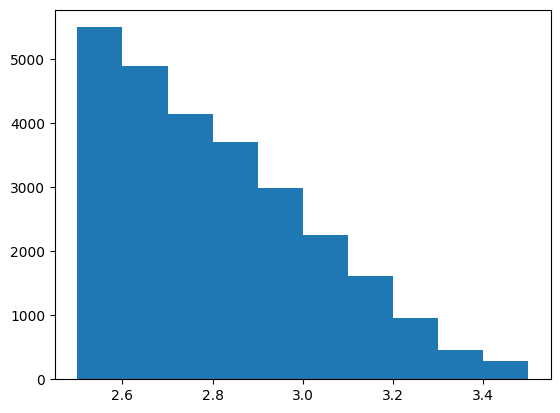

In [45]:
z_min = 2.5
z_max = 3.5
u_indexes = np.where((redshifts > z_min) & (redshifts < z_max) )[0]#& (data[:, 0] - data[:, 1] > 0.0))[0]
u_params = params[u_indexes, :]
u_data = data[u_indexes, :]
labels[u_indexes] = 1
plt.hist(u_params[:, 0])

In [46]:
# calculate colours of a set of photometry
def calculate_colours(photometry):
    
    photo1 = photometry[:,:-1]
    photo2 = photometry[:,1:]
    colours = photo1 - photo2

    return colours

In [47]:
#From photometry want to predict label
print(data.shape)
data = calculate_colours(data)


dataset = tf.data.Dataset.from_tensor_slices((data, labels))

validation_split = 0.9
train_size = int(validation_split * data.shape[0])
test_size = data.shape[0] - train_size

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

train_dataset = train_dataset.batch(batch_size=1000)

(355856, 6)


In [48]:
depth = 32
model = tfdf.keras.RandomForestModel(max_depth=depth, verbose=2)
model.fit(train_dataset)

Use 10 thread(s) for training
Use /var/folders/s9/j1tshp4s5019kbkk8hz2q9840000gn/T/tmplx34r5v4 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: Tensor("data:0", shape=(None, 5), dtype=float64)
Label: Tensor("data_1:0", shape=(None,), dtype=float64)
Weights: None
Normalized tensor features:
 {'data:0.0': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice:0' shape=(None,) dtype=float32>), 'data:0.1': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_1:0' shape=(None,) dtype=float32>), 'data:0.2': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_2:0' shape=(None,) dtype=float32>), 'data:0.3': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_3:0' shape=(None,) dtype=float32>), 'data:0.4': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_4:0' shape=(None,) dtype=float32>)}
Training dat

In [49]:
model.save("saved_models/test_"+str(depth)+"_"+str(data.shape))

INFO:tensorflow:Assets written to: saved_models/test_32_(355856, 5)/assets


INFO:tensorflow:Assets written to: saved_models/test_32_(355856, 5)/assets


In [50]:
model.compile(metrics=["accuracy"])
evaluation = model.evaluate(test_dataset.batch(batch_size=1000), return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

36/36 [==============================] - 3s 29ms/step - loss: 0.0000e+00 - accuracy: 0.9803

loss: 0.0000
accuracy: 0.9803


In [51]:
print(model.make_inspector().extract_tree(1))

(data:0.2 >= 0.4361005127429962; miss=True, score=0.04912015423178673)
    ├─(pos)─ (data:0.0 >= 3.3269119262695312; miss=False, score=0.005623157601803541)
    │        ├─(pos)─ (data:0.4 >= 0.4582468271255493; miss=False, score=0.13304206728935242)
    │        │        ├─(pos)─ (data:0.2 >= 0.9013665914535522; miss=False, score=0.18257848918437958)
    │        │        │    ...
    │        │        └─(neg)─ (data:0.3 >= 0.2357063889503479; miss=True, score=0.10657108575105667)
    │        │             ...
    │        └─(neg)─ (data:0.2 >= 0.628130316734314; miss=True, score=0.004128353204578161)
    │                 ├─(pos)─ (data:0.4 >= 0.6645992398262024; miss=False, score=0.0010568557772785425)
    │                 │    ...
    │                 └─(neg)─ (data:0.0 >= 1.205286979675293; miss=False, score=0.014648077078163624)
    │                      ...
    └─(neg)─ (data:0.0 >= 0.9015166759490967; miss=True, score=0.10905341058969498)
             ├─(pos)─ (data:0.3 >= 

In [52]:
predicted_labels = model.predict(test_dataset.batch(batch_size=1000))

36/36 [==============================] - 1s 28ms/step


In [53]:
predicted_labels[:, 0].max()

0.99999917

tf.Tensor(
[[32724   259]
 [  443  2160]], shape=(2, 2), dtype=int32)
efficency(%):  82.98117556665386
purity(%):  89.29309632079372
interloper fraction(%):  2.7697395618023974


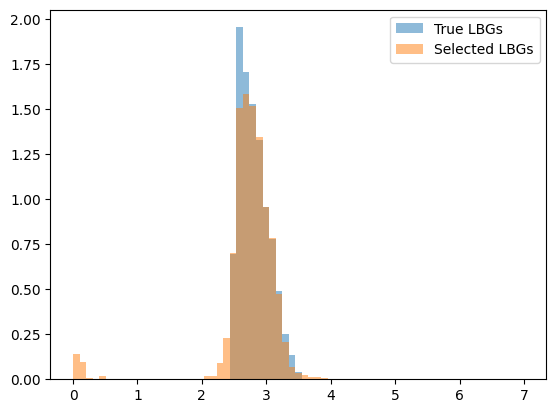

: 

In [62]:
confidence_level = 0.5 #hyperparameter(ideal value depends on survey size? The larger your initial set of galaxies, the lower your efficency can be)
predictions = predicted_labels[:, 0]
predicted_labels_at_confidence = np.where(predictions > confidence_level, 1.0, 0.0)
cmatrix = tf.math.confusion_matrix(labels[train_size:], predicted_labels_at_confidence)

print(cmatrix)
# TN FP
# FN TP

z_bins = np.linspace(0.0, 7.0, 70)

test_set_redshifts = redshifts[train_size:]
test_set_lbgs = test_set_redshifts[np.where((test_set_redshifts > 2.5) & (test_set_redshifts < 3.5) )[0]]

selected_lbgs = test_set_redshifts[np.where(predicted_labels_at_confidence == 1.0)[0]]

plt.hist(test_set_lbgs, bins=z_bins, label="True LBGs", density=True, alpha=0.5)
plt.hist(selected_lbgs, bins=z_bins, label="Selected LBGs", density=True, alpha=0.5)
plt.legend()

ninterlopers =  (np.where(selected_lbgs < 1.5)[0]).shape[0]

print("efficency(%): ", float(((cmatrix[1, 1])/test_set_lbgs.shape[0])*100))
print("purity(%): ", float((cmatrix[1, 1]/(cmatrix[0,1]+cmatrix[1, 1]))*100)) #of all positives - which are truly lbgs?
print("interloper fraction(%): ", (ninterlopers/selected_lbgs.shape[0])*100) 

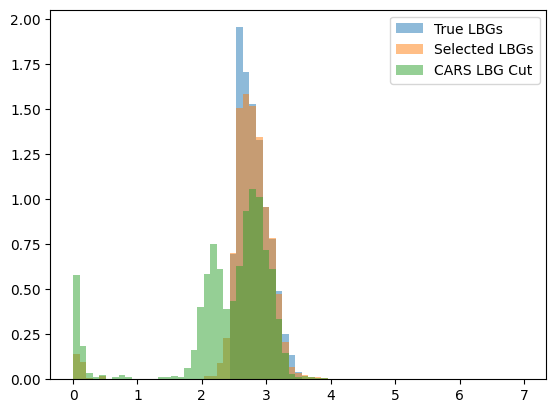

In [55]:
data_test = data[train_size:]
umg = data_test[:, 0]
gmr = data_test[:, 1]
selected_lbgs_trad = test_set_redshifts[np.where((gmr > -1.0) & (gmr < 1.2) & (umg > 0.75 + 1.5*gmr))[0]]
plt.hist(test_set_lbgs, bins=z_bins, label="True LBGs", density=True, alpha=0.5)
plt.hist(selected_lbgs, bins=z_bins, label="Selected LBGs", density=True, alpha=0.5)
plt.hist(selected_lbgs_trad, bins=z_bins, label="CARS LBG Cut", density=True, alpha=0.5)
plt.legend()